In [1]:
# pandas-or-bears classification model with CNN
# train : 500 images [pandas(250) + bears(250)] , 
# validation : 100 images [pandas(50) + bears(50)] , 300*300 pixels

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
# 사전 훈련된 가중치 불러오기
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(256,256,3),
                                include_top = False,
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

# 사전 훈련 계층의 가중치의 훈련(학습) 가능 여부를 설정 : False(학습 안함)
for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

# 마지막 층 출력 확인하기
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape : ',last_layer.output_shape)       #(None, 7, 7, 768)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [4]:
train_dir = 'tmp/PandasBears/Train'
validation_dir = 'tmp/PandasBears/Test'
# 이미지 데이터 경로 설정
import os

base_dir = 'tmp/PandasBears'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Test')

# Directory with our training cat/dog pictures
train_Pandas_dir = os.path.join(train_dir, 'Pandas')
train_Bears_dir = os.path.join(train_dir, 'Bears')

# Directory with our validation cat/dog pictures
validation_Pandas_dir = os.path.join(validation_dir, 'Pandas')
validation_Bears_dir = os.path.join(validation_dir, 'Bears')

train_Pandas_names = os.listdir( train_Pandas_dir )
train_Bears_names = os.listdir( train_Bears_dir )

In [5]:
# 모델구성/컴파일
# Flatten Layer
x = layers.Flatten()(last_output)
# Dense Layer : Hidden Layer
x = layers.Dense(1024,activation='relu')(x) # (None,1024)
#Dropout layer
x = layers.Dropout(0.2)(x)
# Dense Layer : Final output Layer
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics =['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(256, 256),  # All images will be resized to 150x150
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=10,
        class_mode='binary')

Found 500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [7]:
# 학습
# 사전 훈련 가중치는 업데이트 하지 않고 추가 계층만 가중치 업데이트하여 학습
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 20,
            validation_steps = 10,
            verbose = 1)

Epoch 1/20
50/50 [==============================] - 12s 97ms/step - loss: 0.2872 - accuracy: 0.9520 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 2/20
50/50 [==============================] - 4s 86ms/step - loss: 0.0111 - accuracy: 0.9980 - val_loss: 4.6251e-07 - val_accuracy: 1.0000
Epoch 3/20
50/50 [==============================] - 4s 84ms/step - loss: 1.4041e-04 - accuracy: 1.0000 - val_loss: 8.0258e-08 - val_accuracy: 1.0000
Epoch 4/20
50/50 [==============================] - 4s 84ms/step - loss: 3.0636e-06 - accuracy: 1.0000 - val_loss: 1.9624e-08 - val_accuracy: 1.0000
Epoch 5/20
50/50 [==============================] - 4s 85ms/step - loss: 0.0034 - accuracy: 0.9980 - val_loss: 4.5018e-10 - val_accuracy: 1.0000
Epoch 6/20
50/50 [==============================] - 4s 85ms/step - loss: 1.1757e-07 - accuracy: 1.0000 - val_loss: 4.7865e-10 - val_accuracy: 1.0000
Epoch 7/20
50/50 [==============================] - 4s 86ms/step - loss: 7.2755e-06 - accuracy: 1.0000 - val_loss: 2.5574

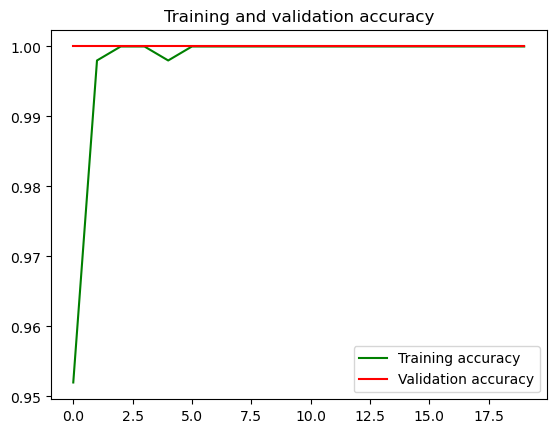

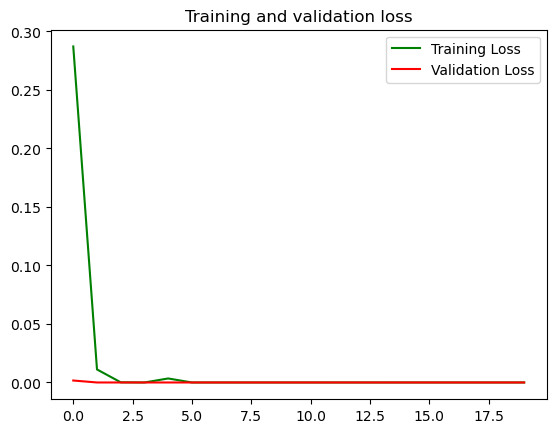

In [8]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
import numpy as np
from tensorflow.keras.preprocessing import image
def image_predict(file_name):
    path = 'tmp/pandd/' + file_name + '.jpg'
    img = image.load_img(path, target_size=(256, 256))
    x = image.img_to_array(img)   # 2차원 ndarray로 변환
    x = np.expand_dims(x, axis=0) # 3차원으로 변환
    images = np.vstack([x])       # 4차원으로 변환
    classes = model.predict(images, batch_size=10)
    # print(classes[0],end=' ')
    if classes[0] == 1.0:
        print(file_name ,': panda')
    else:
        print(file_name ,': bear')

image_predict('panda1')        
image_predict('panda2')
image_predict('panda3')        
image_predict('panda4')
image_predict('panda5')        
image_predict('panda6')
image_predict('bear1')
image_predict('bear2')
image_predict('bear3')
image_predict('bear4')
image_predict('bear5')
image_predict('bear6')

1/1 [==============================] - 1s 541ms/step
panda1 : panda
1/1 [==============================] - 0s 16ms/step
panda2 : panda
1/1 [==============================] - 0s 16ms/step
panda3 : panda
1/1 [==============================] - 0s 17ms/step
panda4 : panda
1/1 [==============================] - 0s 18ms/step
panda5 : panda
1/1 [==============================] - 0s 18ms/step
panda6 : panda
1/1 [==============================] - 0s 16ms/step
bear1 : panda
1/1 [==============================] - 0s 14ms/step
bear2 : panda
1/1 [==============================] - 0s 15ms/step
bear3 : panda
1/1 [==============================] - 0s 14ms/step
bear4 : panda
1/1 [==============================] - 0s 14ms/step
bear5 : panda
1/1 [==============================] - 0s 14ms/step
bear6 : panda
